In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
import pandas as pd




# number of data
N=4000
# size of each sample
L=2
# box size
B=100

!mkdir DATA

A subdirectory or file DATA already exists.


**Non-linear functions**

In [61]:
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

def boundaries():  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)

**Genererate Data**

<function matplotlib.pyplot.show(close=None, block=None)>

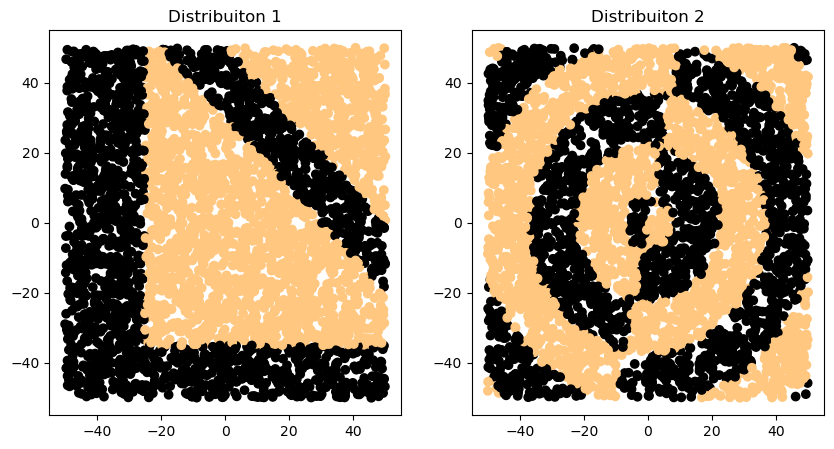

In [62]:
TYPE=1

# random seed for reproducibility
np.random.seed(12345)

def generate_data(TYPE):
    x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
    for i in range(N):
        # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return x, y

x1, y1 = generate_data(1)
x2, y2 = generate_data(2)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis[0].scatter(x1[:,0],x1[:,1],c=y1,cmap=cm.copper)
axis[0].set_title("Distribuiton 1")
axis[1].scatter(x2[:,0],x2[:,1],c=y2,cmap=cm.copper)
axis[1].set_title("Distribuiton 2")

plt.show

***Distribution 1***

In [63]:
#Number of total samples
N=len(x1)
#Training set
perc_train=0.8
N_train = int(perc_train * N)

#Split training and validation set 
(x1_train, y1_train) = (x1[0:N_train],y1[0:N_train])
(x1_valid, y1_valid) = (x1[N_train:],y1[N_train:])
print("Train:",len(x1_train),"\t Validation:",len(x1_valid))

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x1_train = Rescale(x1_train)
x1_valid = Rescale(x1_valid)


Train: 3200 	 Validation: 800


**Define DNN**

In [64]:
# fix random seed for reproducibility
seed = 12345
tf.random.set_seed(seed)

def base_model():
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

def create_model(optimizer=optimizer):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [65]:
model = KerasClassifier(model=base_model)
base_model = model.fit(x1_train, y1_train,
               epochs = 500, batch_size = 50,
               validation_data=(x1_valid,y1_valid),
               verbose=2)

Epoch 1/500
64/64 - 1s - loss: 0.6792 - accuracy: 0.5784 - val_loss: 0.6690 - val_accuracy: 0.6125 - 941ms/epoch - 15ms/step
Epoch 2/500
64/64 - 0s - loss: 0.6644 - accuracy: 0.6456 - val_loss: 0.6592 - val_accuracy: 0.6100 - 79ms/epoch - 1ms/step
Epoch 3/500
64/64 - 0s - loss: 0.6544 - accuracy: 0.6506 - val_loss: 0.6490 - val_accuracy: 0.6237 - 83ms/epoch - 1ms/step
Epoch 4/500
64/64 - 0s - loss: 0.6441 - accuracy: 0.6609 - val_loss: 0.6382 - val_accuracy: 0.6600 - 83ms/epoch - 1ms/step
Epoch 5/500
64/64 - 0s - loss: 0.6319 - accuracy: 0.6806 - val_loss: 0.6230 - val_accuracy: 0.6737 - 92ms/epoch - 1ms/step
Epoch 6/500
64/64 - 0s - loss: 0.6117 - accuracy: 0.6881 - val_loss: 0.5961 - val_accuracy: 0.7063 - 96ms/epoch - 2ms/step
Epoch 7/500
64/64 - 0s - loss: 0.5818 - accuracy: 0.7141 - val_loss: 0.5545 - val_accuracy: 0.7462 - 140ms/epoch - 2ms/step
Epoch 8/500
64/64 - 0s - loss: 0.5442 - accuracy: 0.7325 - val_loss: 0.5086 - val_accuracy: 0.7675 - 189ms/epoch - 3ms/step
Epoch 9/500


In [66]:
#Test accuracy of data
dX = 2
X1 = np.arange(-50,50+dX, dX)

LG = len(X1)
grid = np.zeros((LG*LG,2))
#print(grid)
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
grid_r=grid/50
pred = base_model.predict(grid_r)




82/82 [==============================] - 0s 722us/step


<function matplotlib.pyplot.show(close=None, block=None)>

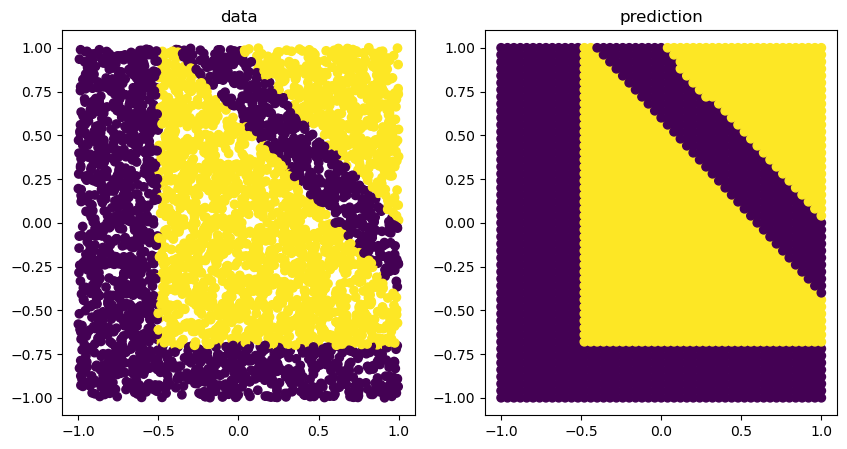

In [67]:

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Total data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated data

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred)
axis[1].set_title("prediction")

plt.show

**Tune Batch Size, number of epochs and algorithm**

In [68]:
def create_model(optimizer='adam'):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


#create model 
model = KerasClassifier(model=create_model, verbose = 0)

#define the grid search parameters
batch_size = [ 40, 60 ]
epochs = [10,50,100]
optimizer = [ "Adam", "Adamax", "Nadam" ]
param_grid = dict(batch_size=batch_size, epochs= epochs,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result=grid.fit(x1,y1)

In [69]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'batch_size': 40, 'epochs': 100, 'optimizer': 'Adam'}
The accuracy obtained for those previous values is: 0.8730014212698602


In [70]:
result_6 = pd.DataFrame(grid_result.cv_results_)
result = result_6[["param_batch_size","param_epochs", "param_optimizer","mean_test_score" ]]
result

,param_batch_size,param_epochs,param_optimizer,mean_test_score
0,40,10,Adam,0.791742
1,40,10,Adamax,0.737999
2,40,10,Nadam,0.722980
3,40,50,Adam,0.776730
4,40,50,Adamax,0.736490
5,40,50,Nadam,0.836252
6,40,100,Adam,0.873001
7,40,100,Adamax,0.792026
8,40,100,Nadam,0.787756
9,60,10,Adam,0.712241


**Tune activation function and optimization algorithm**

In [71]:
def create_model(optimizer='adam', activation="relu"):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(2,input_shape=(2,),activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dense(20,activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


#create model 
model = KerasClassifier(model=create_model,epochs=100, batch_size=40, verbose = 0)

#define the grid search parameters
optimizer = ["SGD", "Adagrad",  "Adam",  "Nadam" ]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
param_grid = dict(model__activation=activation ,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(x1,y1)



In [72]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'model__activation': 'relu', 'optimizer': 'Adagrad'}
The accuracy obtained for those previous values is: 0.8752512340978797


In [77]:
result_6 = pd.DataFrame(grid_result.cv_results_)
result_6
result = result_6[["param_model__activation", "param_optimizer","mean_test_score" ]]
result

,param_model__activation,param_optimizer,mean_test_score
0,softmax,SGD,0.682996
1,softmax,Adagrad,0.767752
2,softmax,Adam,0.724741
3,softmax,Nadam,0.740265
4,relu,SGD,0.807755
5,relu,Adagrad,0.875251
6,relu,Adam,0.832999
7,relu,Nadam,0.870753
8,tanh,SGD,0.703764
9,tanh,Adagrad,0.697985
